# Project for Course 4: Employee Turnover Analytics
## By John Hamilton

### 1. Perform data quality check

Load in the data and take a quick look at the head:

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load the data using Pandas
df = pd.read_excel("hr_comma_sep.xlsx")
df.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Look at the info for the data columns:

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


Convert objects to categories:

In [24]:
df['sales'] = pd.Categorical(df['sales'])
df['salary'] = pd.Categorical(df['salary'])

Check for missing values:

In [25]:
def missing_values(df):
        '''This handy function will show us which columns (if any) have NaN or NULL values'''
        nans = df.isna().sum()
        nulls = df.isnull().sum()
        table = pd.concat([nans, nulls], axis=1)
        table = table.rename(columns = {0 : 'NaN Count', 1 : 'NULL Count'})
        return table

# Check the data for missing values
print(missing_values(df))

                       NaN Count  NULL Count
satisfaction_level             0           0
last_evaluation                0           0
number_project                 0           0
average_montly_hours           0           0
time_spend_company             0           0
Work_accident                  0           0
left                           0           0
promotion_last_5years          0           0
sales                          0           0
salary                         0           0


Check the number of unique values per column:

In [26]:
df.nunique()

satisfaction_level        92
last_evaluation           65
number_project             6
average_montly_hours     215
time_spend_company         8
Work_accident              2
left                       2
promotion_last_5years      2
sales                     10
salary                     3
dtype: int64

- Observation: "Work_accident", "left", and "promotion_last_5years" are all boolean columns with 2 unique values (1 and 0)

Check the percentage of each column that is zero:

In [27]:
df[df==0].count()/df.count()*100

satisfaction_level        0.000000
last_evaluation           0.000000
number_project            0.000000
average_montly_hours      0.000000
time_spend_company        0.000000
Work_accident            85.539036
left                     76.191746
promotion_last_5years    97.873192
sales                     0.000000
salary                    0.000000
dtype: float64

- Observation: The three boolean columns are imbalanced (mostly zeros). We may need to use something like SMOTE later.

### 2. Understand what factors contributed most to employee turnover by EDA

Draw a Heatmap of the Correlation Matrix between all numberical columns:

<Axes: >

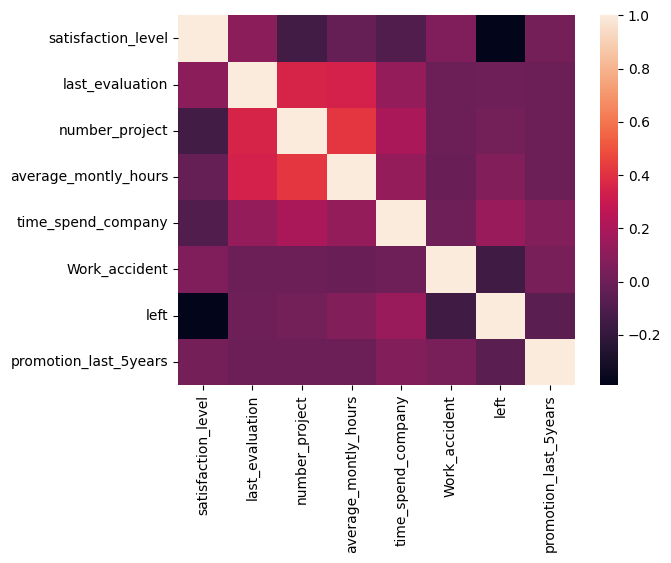

In [28]:
df_numerical = df.select_dtypes(include=[np.number])
sns.heatmap(df_numerical.corr())

Draw a distribution plot for Employee Satisfaction, Employee Evaluation, and Employee Average Monthly Hours:

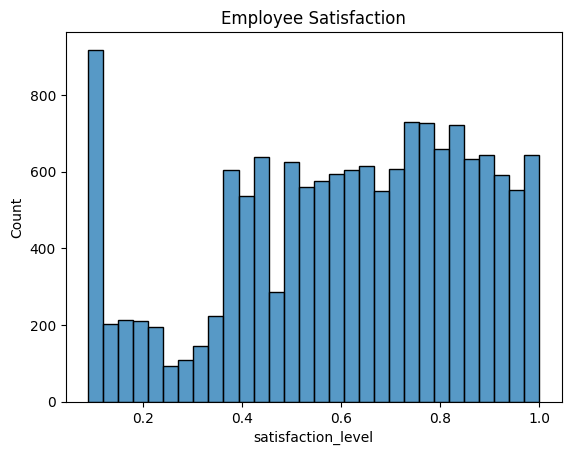

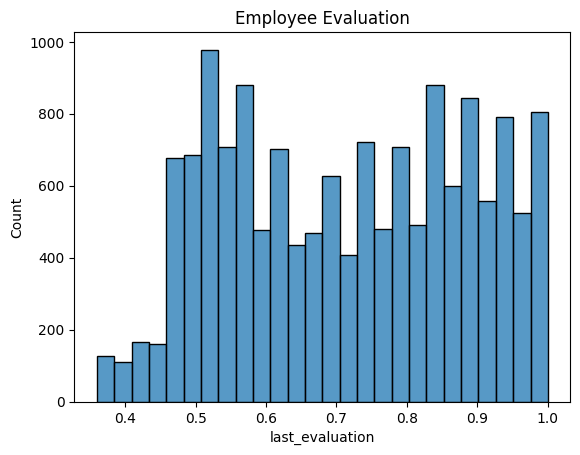

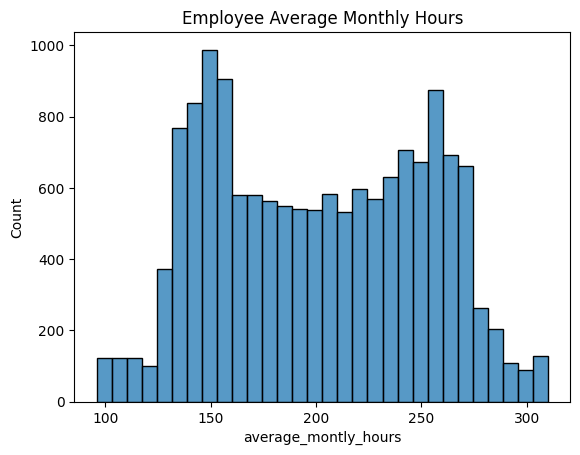

In [29]:
sns.histplot(df['satisfaction_level']).set_title('Employee Satisfaction')
plt.show()
plt.clf() # this clears the figure
sns.histplot(df['last_evaluation']).set_title("Employee Evaluation")
plt.show()
plt.clf() # this clears the figure
sns.histplot(df['average_montly_hours']).set_title('Employee Average Monthly Hours')
plt.show()

Draw the bar plot of Employee Project Count of employees who left and stayed:

Text(0.5, 0, 'Number of Projects')

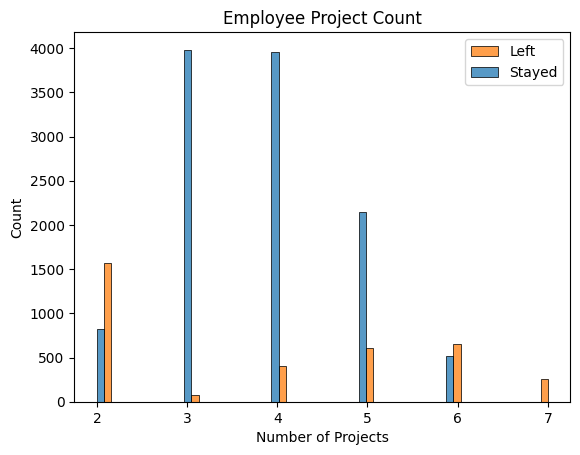

In [30]:
sns.histplot(df, x='number_project', hue='left', multiple='dodge').set_title("Employee Project Count")
plt.legend(['Left','Stayed'])
plt.xlabel('Number of Projects')

- Observations:
1. Many more workers left than stayed when they had too few projects (2 projects)
2. More workers left than stayed when they had too many projects (more than 5 projects)
3. Every worker who had over 6 projects got burnt out and left
4. The optimal number of projects for employee retention is 3 to 5

### 3. Perform clustering of employees who left

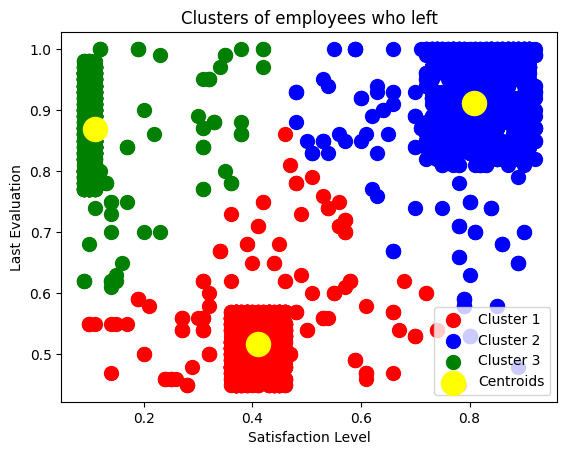

In [31]:
from sklearn.cluster import KMeans

X = df[df['left']==1].iloc[:, [0, 1]].values
model = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = model.fit_predict(X)

plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of employees who left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.legend()
plt.show()

- Observations:
1. The green cluster indicates that employees who did well on their evaluation but poor on satisfaction have left
2. The red cluster indicates that those of average satisfaction who did poor on their evaluation have left
3. The blue cluster indicates that even those with high satisfaction and high evaluation have left

### 4. Handle the Left imbalance using the SMOTE technique

Convert categorical columns to numeric:

In [32]:
df_numerical = df.select_dtypes(include=[np.number])
df_categorical = df.select_dtypes(include=['category'])
df_categorical = pd.get_dummies(df_categorical, columns=['sales', 'salary'])
df = pd.concat([df_numerical, df_categorical], axis=1)

Split the data into Train and Test:

In [33]:
from sklearn.model_selection import train_test_split

X = df.drop(['left'], axis=1)
y = df['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

Apply SMOTE technique:

In [34]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
transformed_feature_df, transformed_label_df = oversample.fit_resample(X_train, y_train)

print(f'new label count: {transformed_label_df.value_counts()}')
print(f'old label count: {y_train.value_counts()}')

new label count: left
0    9142
1    9142
Name: count, dtype: int64
old label count: left
0    9142
1    2857
Name: count, dtype: int64


Replace training data with SMOTE data from above (for use below)

In [35]:
X_train = transformed_feature_df
y_train = transformed_label_df

### 5. Perform 5-fold cross-validation model training and evaluate performance

Write method to perform Cross-Validation and Classification Report for any model

In [36]:
from sklearn.metrics import classification_report
from sklearn import model_selection

def measure_model(model_input):
    model = model_input.fit(X_train, y_train)
    results = model_selection.cross_val_score(model, X_train, y_train, cv=5)
    print('<' + model_input.__class__.__name__ + '>', 'Cross-Validation score:', results.mean()*100, 'percent')
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))

Apply this method for LogisticRegression, RandomForestClassifier, and GradientBoostingClassifier


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

logistic_regression_model = LogisticRegression(solver='liblinear')
random_forest_classifier = RandomForestClassifier(n_estimators=20, random_state=0)
gradient_boosting_classifier = GradientBoostingClassifier(learning_rate=0.1)

measure_model(logistic_regression_model)
measure_model(random_forest_classifier)
measure_model(gradient_boosting_classifier)

<LogisticRegression> Cross-Validation score: 80.37640710630193 percent
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      2286
           1       0.53      0.71      0.61       714

    accuracy                           0.78      3000
   macro avg       0.71      0.76      0.73      3000
weighted avg       0.81      0.78      0.79      3000

<RandomForestClassifier> Cross-Validation score: 98.12952468483151 percent
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000

<GradientBoostingClassifier> Cross-Validation score: 96.30278013629328 percent
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2286
           1

### 6. Identify the best model and justify metrics used

Write a method to calculate ROC/AUC score, graph it, and then display the Confusion Matrix

In [38]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix

def model_metrics(model_input):
    model = model_input.fit(X_train, y_train)
    print('<' + model_input.__class__.__name__ + '> ROC/AUC score:', roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    y_pred = model.predict(X_test)
    RocCurveDisplay.from_predictions(y_test, y_pred)              
    plt.show()
    print('<' + model_input.__class__.__name__ + '> Confusion matrix:')
    display(confusion_matrix(y_test, y_pred))

Apply this method for LogisticRegression, RandomForestClassifier, and GradientBoostingClassifier


<LogisticRegression> ROC/AUC score: 0.8807104140362316


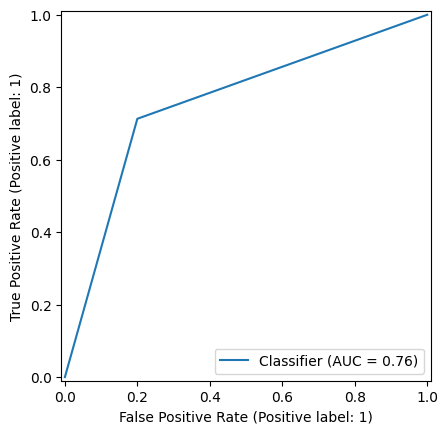

<LogisticRegression> Confusion matrix:


array([[1829,  457],
       [ 205,  509]], dtype=int64)

<RandomForestClassifier> ROC/AUC score: 0.9999998384706913


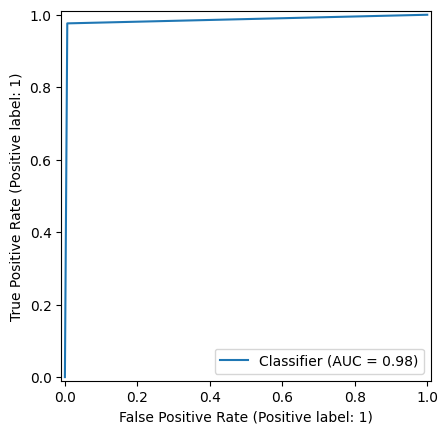

<RandomForestClassifier> Confusion matrix:


array([[2271,   15],
       [  17,  697]], dtype=int64)

<GradientBoostingClassifier> ROC/AUC score: 0.9932964977909251


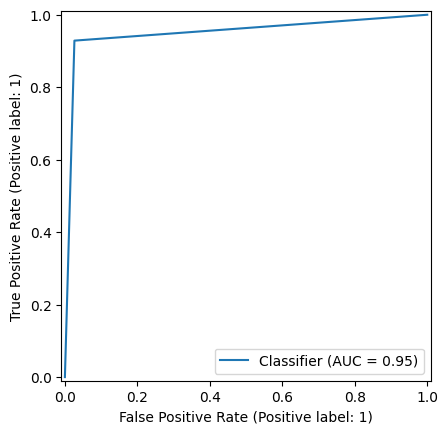

<GradientBoostingClassifier> Confusion matrix:


array([[2226,   60],
       [  51,  663]], dtype=int64)

In [39]:
model_metrics(logistic_regression_model)
model_metrics(random_forest_classifier)
model_metrics(gradient_boosting_classifier)

- Observations:
1. Recall is more important than Precision because what is important is that those employees who truly will leave are properly anticipated.
2. According to Recall score found in the Classification Reports in section (5) above, the RandomForestClassifier is the best model.
3. The confusion matrices above also indicate that Recall is best for the RandomForestClassifier.
4. Incidentally, this is an easy decision, since Precision and Accuracy are also best with RandomForestClassifier.

### 7. Suggest various retention strategies for targeted employees


Using the best model (Random Forest), predict the probability of employee turnover in the test data

In [40]:
model = random_forest_classifier.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:,1]
zones = []
for prob in y_prob:
    zones.append('safe' if prob < .2 else 'low' if prob < .6 else 'medium' if prob < .9 else 'high')
pd.Series(zones).value_counts()

safe      2135
high       665
low        159
medium      41
Name: count, dtype: int64

Now let's visualize this:

Text(0.5, 1.0, 'Employee Turnover Zones')

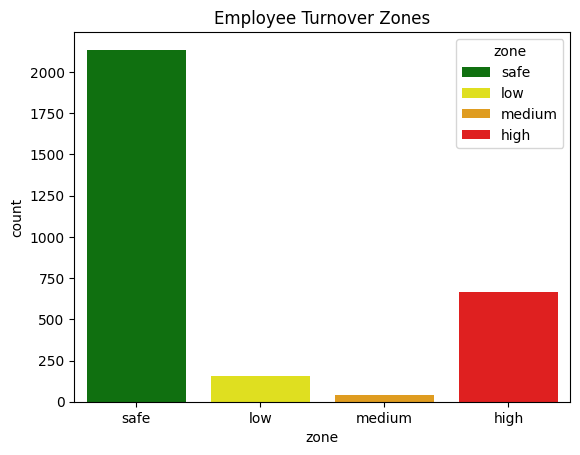

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns; 

counts = pd.DataFrame(pd.Series(zones).value_counts().rename_axis('zone').loc[['safe','low','medium','high']])
colors = ["green", "yellow", "orange", "red"]
sns.barplot(data=counts, x='zone', y='count', palette=colors, hue='zone', legend=True)
plt.title("Employee Turnover Zones")


Retention strategies:
1. Most employees are in the safe zone, so those people are not a problem although we should make sure they stay happy
2. Even so, there are a large number of people in the high zone, so we need to find out what is important for those people and fix it
3. The number of people in low and medium is relatively small, so these zones may not need as much attention as the high zone